In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import jax

In [4]:
download_data=False

if download_data:
    !wget https://archive.ics.uci.edu/static/public/501/beijing+multi+site+air+quality+data.zip
    !unzip beijing+multi+site+air+quality+data.zip
    !unzip PRSA2017_Data_20130301-20170228.zip

In [6]:
import glob
import pandas as pd

path = 'data/PRSA_Data_20130301-20170228/'
csv_files = glob.glob(path + "/*.csv")

# Read each CSV file into DataFrame
# This creates a list of dataframes
df_list = [pd.read_csv(file) for file in csv_files]

In [7]:
def pre_process(df):
    df['date_time']=pd.to_datetime(df[['year', 'month', 'day','hour']])
    df.drop(columns=['year', 'month', 'day','hour','No'],inplace=True)
    df.set_index('date_time',inplace=True)
    return df

In [8]:
df_preprocessed=[pre_process(df) for df in df_list]

In [9]:
df_preprocessed[0]

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
date_time,,,,,,,,,,,,,
2013-03-01 00:00:00,6.0,18.0,5.0,NaN,800.0,88.0,0.1,1021.1,-18.6,0.0,NW,4.4,Gucheng
2013-03-01 01:00:00,6.0,15.0,5.0,NaN,800.0,88.0,-0.3,1021.5,-19.0,0.0,NW,4.0,Gucheng
2013-03-01 02:00:00,5.0,18.0,NaN,NaN,700.0,52.0,-0.7,1021.5,-19.8,0.0,WNW,4.6,Gucheng
2013-03-01 03:00:00,6.0,20.0,6.0,NaN,NaN,NaN,-1.0,1022.7,-21.2,0.0,W,2.8,Gucheng
2013-03-01 04:00:00,5.0,17.0,5.0,NaN,600.0,73.0,-1.3,1023.0,-21.4,0.0,WNW,3.6,Gucheng
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-28 19:00:00,14.0,58.0,4.0,19.0,500.0,56.0,12.8,1009.9,-17.0,0.0,NNW,3.1,Gucheng
2017-02-28 20:00:00,27.0,83.0,6.0,60.0,700.0,26.0,11.1,1010.4,-15.5,0.0,NW,1.9,Gucheng
2017-02-28 21:00:00,22.0,37.0,7.0,52.0,600.0,27.0,10.5,1010.8,-15.9,0.0,N,2.3,Gucheng


In [10]:
df_group=pd.concat(df_preprocessed)

In [11]:
def train_test_split(data,split_fraction,feature_keys):
    data=data[feature_keys]
    train_split = int(split_fraction * int(data.shape[0]))
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    data = (data - data_mean) / data_std
    train_data = data.iloc[0 : train_split - 1]
    val_data = data.iloc[train_split:]
    return train_data,val_data

def create_batch(data,lag,future):
    df_lag=pd.concat([data[:-future].shift(i) for i in range(lag-1,-1,-1)],axis=1).dropna()
    #df_lag.columns=['pm_'+str(i) for i in range(lag,-1,1)]
    X=df_lag.values
    y=data[future+lag-1:].values
    return X,y

def create_batch_multistep(df,lag,future,feature=None):
    if feature is None:
        data=df
    else:
        data=df[feature]
    df_lag=pd.concat([data[:-future].shift(i) for i in range(lag-1,-1,-1)],axis=1).dropna()
    df_future=pd.concat([data[lag-1:].shift(-i) for i in range(1,future+1)],axis=1).dropna()
    #df_lag.columns=['pm_'+str(i) for i in range(lag,-1,1)]
    X=df_lag.values
    y=df_future.values
    return X,y

In [12]:
df_group.columns

Index(['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP',
       'RAIN', 'wd', 'WSPM', 'station'],
      dtype='object')

In [13]:
import numpy as np

split_fraction = 0.8
feature_keys = ['PM2.5','TEMP','PRES','DEWP','PM10','WSPM']
X_train_datasets=list()
y_train_datasets=list()
X_test_datasets=list()
y_test_datasets=list()
future=6
past=6
dataset_names=list()
for item_id, gdf in df_group.groupby('station'):
    #gdf.fillna(method='ffill',inplace=True)
    gdf.ffill(inplace=True)
    train,test=train_test_split(gdf,split_fraction,feature_keys)
    train_multi_feature=list()
    test_multi_feature=list()
    for feature in feature_keys:
        X_train,y_train=create_batch_multistep(train,past,future,feature)
        X_test,y_test=create_batch_multistep(test,past,future,feature)
        train_multi_feature.append(X_train)
        test_multi_feature.append(X_test)
        if feature=='PM2.5':
            y_train_datasets.append(y_train)
            y_test_datasets.append(y_test)
    X_train_datasets.append(np.stack(train_multi_feature,axis=-1))
    X_test_datasets.append(np.stack(test_multi_feature,axis=-1))
    dataset_names.append(item_id)
X_train_datasets=np.stack(X_train_datasets,axis=0)
y_train_datasets=np.stack(y_train_datasets,axis=0)
X_test_datasets=np.stack(X_test_datasets,axis=0)
y_test_datasets=np.stack(y_test_datasets,axis=0)

In [14]:
X_train_datasets.shape,y_train_datasets.shape

((12, 28039, 6, 6), (12, 28039, 6))

In [15]:
import jax
import jax.numpy as jnp

def get_dataloader(X,y,batch_size,key,axis=0):
    num_train=X.shape[axis]
    indices = jnp.array(list(range(0,num_train)))
    indices=jax.random.permutation(key,indices)
    for i in range(0, len(indices),batch_size):
        batch_indices = jnp.array(indices[i: i+batch_size])
        yield X[:,batch_indices,:,:], y[:,batch_indices]

In [19]:
import optax
from flax import linen as nn
from functools import partial

class LSTM(nn.Module):

    @nn.remat
    @nn.compact
    def __call__(self, X_batch):
        carry,x=nn.RNN(nn.LSTMCell(32),return_carry=True)(X_batch)
        #carry,x=nn.RNN(nn.LSTMCell(32),return_carry=True)(x)
        x=nn.Dense(future)(x)
        return x[:,-1,:]

def log_likelihood(params, x, y):
    preds = jax.vmap(model.apply, (0, 0))(params, jnp.array(x))
    return jnp.mean(optax.l2_loss(y,preds).sum(axis=-1))

grad_log_post=jax.jit(jax.grad(log_likelihood))

@partial(jax.jit, static_argnums=(3,4))
def sgld_kernel_momemtum(key, params, momemtum,grad_log_post, dt, X, y_data):
    gamma,eps=0.9,1e-6
    key, subkey = jax.random.split(key, 2)
    grads = grad_log_post(params, X, y_data)
    squared_grads=jax.tree_map(lambda g: jnp.square(g),grads)
    momemtum=jax.tree_map(lambda m,s : gamma*m+(1-gamma)*s,momemtum,squared_grads)
    noise=jax.tree_map(lambda p: jax.random.normal(key=subkey,shape=p.shape), params)
    params=jax.tree_map(lambda p, g,m,n: p-0.5*dt*g/(m+eps)+jnp.sqrt(dt)*n, params, grads,momemtum,noise)
    return key, params,momemtum

def sgld(key,log_post, grad_log_post, num_samples,
                             dt, x_0,X_train_datasets,y_train_datasets,batch_size,
                             test_data=None):
    samples = list()
    loss=list()
    param = x_0
    key_data, key_model = jax.random.split(key, 2)
    momemtum=jax.tree_map(lambda p:jnp.zeros_like(p),param)
    key_data_batch=jax.random.split(key_data, num_samples)
    for i in range(num_samples):
        train_data=get_dataloader(X_train_datasets,y_train_datasets,batch_size,key_data_batch[i],axis=1)
        for _,(X_batch, y_batch) in enumerate(train_data):
            key_model,param,momemtum = sgld_kernel_momemtum(key_model, param,momemtum, grad_log_post, dt, X_batch, y_batch)
        loss.append(log_post(param,X_batch,y_batch))
        samples.append(param)
        if (i%(num_samples//10)==0):
            print('iteration {0}, loss {1:.2f}'.format(i,loss[-1]))
    return samples,loss


In [18]:
key=jax.random.PRNGKey(0)
key_model,key_data=jax.random.split(key,2)
batch_size=256

In [20]:
model=LSTM()
n_groups=X_train_datasets.shape[0]
n_features=len(feature_keys)
inputs = jax.random.randint(key,(batch_size,past,n_features),0, 10,).astype(jnp.float32)
key_tasks=jax.random.split(key_model,n_groups)
params_tasks = jax.vmap(model.init, (0, None))(key_tasks, inputs)

In [21]:
dt=1e-5
samples,loss=sgld(key_data,log_likelihood, grad_log_post, 50,
                             dt, params_tasks,X_train_datasets,y_train_datasets,
                             batch_size,test_data=None)

iteration 0, loss 0.88
iteration 5, loss 0.55
iteration 10, loss 0.61
iteration 15, loss 0.52
iteration 20, loss 0.51
iteration 25, loss 0.44
iteration 30, loss 0.46
iteration 35, loss 0.41
iteration 40, loss 0.44
iteration 45, loss 0.46


In [22]:
import pickle

with open('sgld.samples', 'wb') as samples_file:
    pickle.dump(samples, samples_file)

# MCMC Model Diagnostics



In [23]:
with open('sgld.samples', 'rb') as samples_file:
    samples = pickle.load(samples_file)

In [25]:
reshaper = lambda s : jax.tree_map(lambda p : p.reshape((n_groups,-1)),s)

flat_params=list()
for s in samples:
    flat_sample=reshaper(s)['params']
    flat_sample=(jax.tree_util.tree_flatten(flat_sample)[0])
    flat_sample=jnp.concatenate(flat_sample,axis=-1)
    flat_params.append(flat_sample)
flat_params=jnp.stack(flat_params,axis=1)

In [26]:
from fortuna.prob_model.posterior.sgmcmc.sgmcmc_diagnostic import effective_sample_size

ess_list=list()

for g in flat_params:
    ess = effective_sample_size(g)
    ess_list.append(ess)
ess_list=jnp.stack(ess_list)

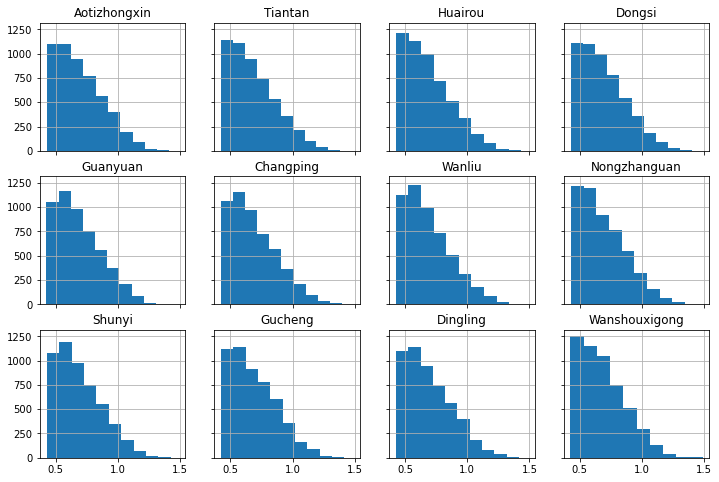

In [27]:
fig, ax = plt.subplots(3, 4, figsize=(12, 8), sharex=True, sharey=True)

for i,ess in enumerate(ess_list):
    j=i%3
    k=i%4
    ax[j,k].grid()
    ax[j,k].hist(jnp.log10(ess))
    ax[j,k].set_title(dataset_names[i])
    #ax[j,k].set_ylabel("Expected Sample Size")
    #ax.set_xlabel("$\Sigma$")
plt.show()

In [28]:
grad_list = list()
for i in range(len(samples)):
    grad=grad_log_post(samples[i], X_train_datasets,y_train_datasets)
    grad_list.append(grad)

In [29]:
flat_grads=list()
for g in grad_list:
    flat_sample=reshaper(g)['params']
    flat_sample=(jax.tree_util.tree_flatten(flat_sample)[0])
    flat_sample=jnp.concatenate(flat_sample,axis=-1)
    flat_grads.append(flat_sample)
flat_grads=jnp.stack(flat_grads,axis=1)

In [28]:
""" from stein_thinning.stein import ksd, kmat
from stein_thinning.thinning import thin
from stein_thinning.kernel import make_imq, make_precon

ksd_samples=list()
for params,grads in zip(flat_params,flat_grads):
    vfk0 = make_imq(np.array(params),np.array(grads), pre='sclmed')
    ks_smp=ksd(np.array(params),np.array(grads),vfk0)
    ksd_samples.append(np.sqrt(np.sum(ks_smp))/len(ks_smp))
log_ksd = np.log10(ksd_samples) """

" from stein_thinning.stein import ksd, kmat\nfrom stein_thinning.thinning import thin\nfrom stein_thinning.kernel import make_imq, make_precon\n\nksd_samples=list()\nfor params,grads in zip(flat_params,flat_grads):\n    vfk0 = make_imq(np.array(params),np.array(grads), pre='sclmed')\n    ks_smp=ksd(np.array(params),np.array(grads),vfk0)\n    ksd_samples.append(np.sqrt(np.sum(ks_smp))/len(ks_smp))\nlog_ksd = np.log10(ksd_samples) "

In [30]:
from fortuna.prob_model.posterior.sgmcmc.sgmcmc_diagnostic import kernel_stein_discrepancy_imq

ksd = jax.vmap(kernel_stein_discrepancy_imq, 0, 0)(flat_params, flat_grads)
log_ksd_float64 = jnp.log10(ksd)

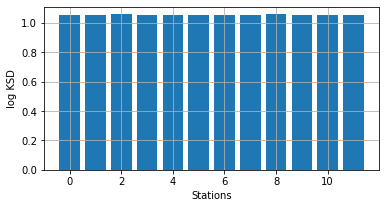

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.grid()
ax.bar(range(len(dataset_names)), log_ksd_float64,width = 0.8)
ax.set_ylabel("log KSD")
#ax.set_xticklabels( dataset_names, rotation=45 )
ax.set_xlabel("Stations")
plt.show()


# Quantization Half Precision

In [74]:
q_samples=[jax.tree_map(lambda p : p.astype(jnp.float16),s) for s in samples]

qflat_params=list()
for s in q_samples:
    flat_sample=reshaper(s)['params']
    flat_sample=(jax.tree_util.tree_flatten(flat_sample)[0])
    flat_sample=jnp.concatenate(flat_sample,axis=-1)
    qflat_params.append(flat_sample)
qflat_params=jnp.stack(qflat_params,axis=1)

In [75]:
qess_list=list()


for g in qflat_params:
    ess = effective_sample_size(g)
    qess_list.append(ess)
qess_list=jnp.stack(ess_list)

In [77]:
ess

Array([4.19     , 5.005522 , 4.0397716, ..., 4.815049 , 3.2157178,
       7.1066957], dtype=float32)

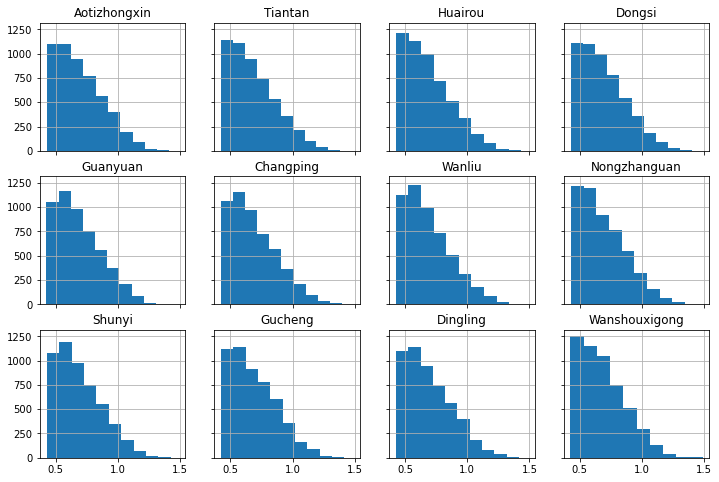

In [78]:
fig, ax = plt.subplots(3, 4, figsize=(12, 8), sharex=True, sharey=True)

for i,ess in enumerate(qess_list):
    j=i%3
    k=i%4
    ax[j,k].grid()
    ax[j,k].hist(jnp.log10(ess))
    ax[j,k].set_title(dataset_names[i])
    #ax[j,k].set_ylabel("Expected Sample Size")
    #ax.set_xlabel("$\Sigma$")
plt.show()

In [79]:
qgrad_list = list()
for i in range(len(q_samples)):
    grad=grad_log_post(q_samples[i], X_train_datasets,y_train_datasets)
    qgrad_list.append(grad)

qflat_grads=list()
for g in qgrad_list:
    flat_sample=reshaper(g)['params']
    flat_sample=(jax.tree_util.tree_flatten(flat_sample)[0])
    flat_sample=jnp.concatenate(flat_sample,axis=-1)
    qflat_grads.append(flat_sample)
qflat_grads=jnp.stack(qflat_grads,axis=1)

In [80]:
q_ksd=list()
for p,g in zip(qflat_params, qflat_grads):
    q_ksd.append(kernel_stein_discrepancy_imq(p,g.astype(jnp.float32)))
log_ksd = jnp.log10(jnp.array(q_ksd))

In [81]:
qflat_grads.shape

(12, 50, 5190)

In [40]:
kernel_stein_discrepancy_imq(qflat_params[0],qflat_grads[0].astype(jnp.float32))

Array(11.387497, dtype=float32)

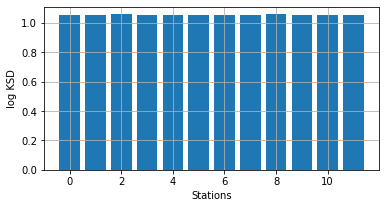

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.grid()
ax.bar(range(len(dataset_names)), log_ksd,width = 0.8)
ax.set_ylabel("log KSD")
#ax.set_xticklabels( dataset_names, rotation=45 )
ax.set_xlabel("Stations")
plt.show()

# Quantization Int8

In [42]:
def quantization(x, s, z, alpha_q, beta_q):
    x_q = jnp.round(1 / s * x + z, decimals=0)
    x_q = jnp.clip(x_q, a_min=alpha_q, a_max=beta_q)
    return x_q


def quantization_int8(x, s, z):
    x_q = quantization(x, s, z, alpha_q=-128, beta_q=127)
    x_q = x_q.astype(jnp.int8)
    return x_q

def dequantization(x_q, s, z):
    # x_q - z might go outside the quantization range.
    x_q = x_q.astype(jnp.int32)
    x = s * (x_q - z)
    x = x.astype(jnp.float16)
    return x


def generate_quantization_constants(alpha, beta, alpha_q, beta_q):
    # Affine quantization mapping
    s = (beta - alpha) / (beta_q - alpha_q)
    z = jnp.int8((beta * alpha_q - alpha * beta_q) / (beta - alpha))
    return s, z


def generate_quantization_int8_constants(alpha, beta):
    b = 8
    alpha_q = -2**(b - 1)
    beta_q = 2**(b - 1) - 1
    s, z = generate_quantization_constants(alpha=alpha,
                                           beta=beta,
                                           alpha_q=alpha_q,
                                           beta_q=beta_q)
    return s, z

In [48]:
from jax.tree_util import tree_flatten, tree_unflatten

flat_params=list()
for s in samples:
    res, schema = tree_flatten(s)
    flat_params.append(res)

flat_params_ensemble=list()
for j in range(schema.num_leaves):
   parm_ens=jnp.stack([flat_params[i][j] for i in range(len(flat_params))])
   flat_params_ensemble.append(parm_ens) 

In [148]:
#jax.tree_map(lambda p,s,z : dequantization(p,s,z),x_q,ss,zz)

In [50]:
len(flat_params_ensemble)

14

In [51]:
def quantize_samples(samples):
    s=list()
    z=list()
    q_samples=list()
    for layer_sample in samples:
        alpha=jnp.min(layer_sample,axis=0)
        beta=jnp.max(layer_sample,axis=0)
        ss,zz=generate_quantization_int8_constants(alpha,beta)
        x_q=quantization_int8(layer_sample,ss,zz)
        q_samples.append(x_q)
        s.append(ss)
        z.append(zz)
    return q_samples,s,z

In [103]:
q_samples_8,s,z=quantize_samples(flat_params_ensemble)


In [104]:
flat_params_ensemble[13].shape

(50, 12, 6, 32)

In [105]:
schema.num_leaves

14

In [106]:
len(q_samples_8)

14

In [107]:
len(q_samples)

50

In [108]:
res=[q_samples_8[j][0,:] for j in range(schema.num_leaves)]

In [109]:
qgrad_list = list()
q_samples_8_unflatten=list()
for i in range(50):
    res=[q_samples_8[j][i,:] for j in range(schema.num_leaves)]
    x_q=schema.unflatten(res)
    ss=schema.unflatten(s)
    zz=schema.unflatten(z)
    sample=jax.tree_map(lambda p,s,z : dequantization(p,s,z),x_q,ss,zz)
    grad=grad_log_post(sample, X_train_datasets,y_train_datasets)
    qgrad_list.append(grad)
    q_samples_8_unflatten.append(sample)


In [110]:
qflat_grads_8=list()
for g in qgrad_list:
    flat_sample=reshaper(g)['params']
    flat_sample=(jax.tree_util.tree_flatten(flat_sample)[0])
    flat_sample=jnp.concatenate(flat_sample,axis=-1)
    qflat_grads_8.append(flat_sample)
qflat_grads_8=jnp.stack(qflat_grads,axis=1)

In [113]:
qflat_params=list()
for s in q_samples_8_unflatten:
    flat_sample=reshaper(s)['params']
    flat_sample=(jax.tree_util.tree_flatten(flat_sample)[0])
    flat_sample=jnp.concatenate(flat_sample,axis=-1)
    qflat_params.append(flat_sample)
qflat_params=jnp.stack(qflat_params,axis=1)

In [114]:
qflat_params.shape

(12, 50, 5190)

In [116]:
qess_list=list()
for g in qflat_params:
    ess = effective_sample_size(g)
    qess_list.append(ess)
qess_list=jnp.stack(ess_list)

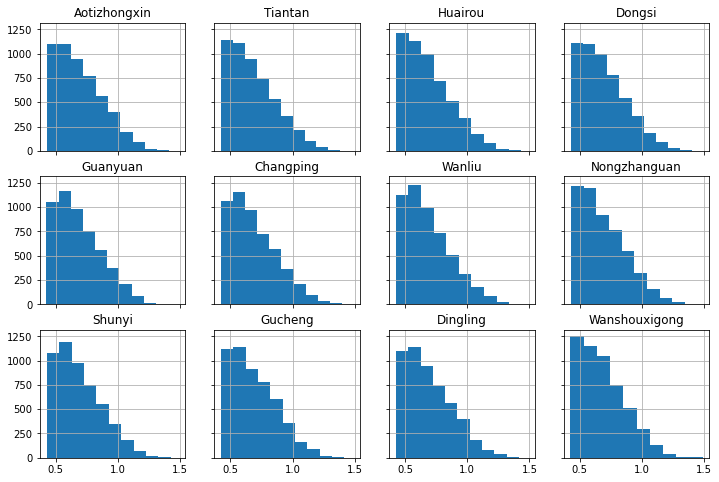

In [118]:
fig, ax = plt.subplots(3, 4, figsize=(12, 8), sharex=True, sharey=True)

for i,ess in enumerate(qess_list):
    j=i%3
    k=i%4
    ax[j,k].grid()
    ax[j,k].hist(jnp.log10(ess))
    ax[j,k].set_title(dataset_names[i])
    #ax[j,k].set_ylabel("Expected Sample Size")
    #ax.set_xlabel("$\Sigma$")
plt.show()

In [119]:
q_ksd=list()
for p,g in zip(qflat_params, qflat_grads):
    q_ksd.append(kernel_stein_discrepancy_imq(p,g.astype(jnp.float32)))
log_ksd = jnp.log10(jnp.array(q_ksd))

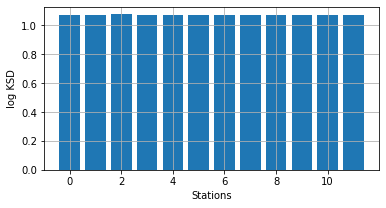

In [121]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.grid()
ax.bar(range(len(dataset_names)), log_ksd,width = 0.8)
ax.set_ylabel("log KSD")
#ax.set_xticklabels( dataset_names, rotation=45 )
ax.set_xlabel("Stations")
plt.show()

# Posterior Predictive

In [122]:
X_test=X_test_datasets
params=samples[-1]
preds=jax.vmap(model.apply, (0, 0))(params, X_test)

In [123]:
from sklearn import metrics
r_metric=list()
rmse_metric=list()
mae_metric=list()
for i in range(n_groups):
    r_squared=metrics.r2_score(preds[i,:,:],y_test_datasets[i,:,:])
    rmse=metrics.mean_squared_error(preds[i,:,:],y_test_datasets[i,:,:],squared=True)
    mae=metrics.mean_absolute_error(preds[i,:,:],y_test_datasets[i,:,:])
    r_metric.append(r_squared)
    rmse_metric.append(rmse)
    mae_metric.append(mae)
    print('task : {0}, RMSE : {1:1.2f}, MAE :{2:1.2f}, R2 :{3:1.2f}'.format(dataset_names[i],rmse,mae,r_squared))
print('-------------------------------------------------------')
print('RMSE : {0:1.2f}, MAE :{1:1.2f}, R2 :{2:1.2f}'.format(np.mean(rmse_metric),np.mean(mae_metric),np.mean(r_metric)))

task : Aotizhongxin, RMSE : 0.24, MAE :0.27, R2 :0.70
task : Changping, RMSE : 0.23, MAE :0.26, R2 :0.71
task : Dingling, RMSE : 0.19, MAE :0.23, R2 :0.77
task : Dongsi, RMSE : 0.32, MAE :0.30, R2 :0.52
task : Guanyuan, RMSE : 0.27, MAE :0.29, R2 :0.69
task : Gucheng, RMSE : 0.33, MAE :0.31, R2 :0.53
task : Huairou, RMSE : 0.21, MAE :0.25, R2 :0.67
task : Nongzhanguan, RMSE : 0.23, MAE :0.27, R2 :0.71
task : Shunyi, RMSE : 0.24, MAE :0.27, R2 :0.67
task : Tiantan, RMSE : 0.25, MAE :0.29, R2 :0.68
task : Wanliu, RMSE : 0.23, MAE :0.26, R2 :0.72
task : Wanshouxigong, RMSE : 0.26, MAE :0.29, R2 :0.69
-------------------------------------------------------
RMSE : 0.25, MAE :0.28, R2 :0.67


In [124]:
X_test=X_test_datasets
params=q_samples[-1]
preds=jax.vmap(model.apply, (0, 0))(params, X_test)

In [125]:
r_metric=list()
rmse_metric=list()
mae_metric=list()
for i in range(n_groups):
    r_squared=metrics.r2_score(preds[i,:,:],y_test_datasets[i,:,:])
    rmse=metrics.mean_squared_error(preds[i,:,:],y_test_datasets[i,:,:],squared=True)
    mae=metrics.mean_absolute_error(preds[i,:,:],y_test_datasets[i,:,:])
    r_metric.append(r_squared)
    rmse_metric.append(rmse)
    mae_metric.append(mae)
    print('task : {0}, RMSE : {1:1.2f}, MAE :{2:1.2f}, R2 :{3:1.2f}'.format(dataset_names[i],rmse,mae,r_squared))
print('-------------------------------------------------------')
print('RMSE : {0:1.2f}, MAE :{1:1.2f}, R2 :{2:1.2f}'.format(np.mean(rmse_metric),np.mean(mae_metric),np.mean(r_metric)))

task : Aotizhongxin, RMSE : 0.24, MAE :0.27, R2 :0.70
task : Changping, RMSE : 0.23, MAE :0.26, R2 :0.71
task : Dingling, RMSE : 0.19, MAE :0.23, R2 :0.77
task : Dongsi, RMSE : 0.32, MAE :0.30, R2 :0.52
task : Guanyuan, RMSE : 0.27, MAE :0.29, R2 :0.69
task : Gucheng, RMSE : 0.33, MAE :0.31, R2 :0.53
task : Huairou, RMSE : 0.21, MAE :0.25, R2 :0.67
task : Nongzhanguan, RMSE : 0.23, MAE :0.27, R2 :0.71
task : Shunyi, RMSE : 0.24, MAE :0.27, R2 :0.67
task : Tiantan, RMSE : 0.25, MAE :0.29, R2 :0.68
task : Wanliu, RMSE : 0.23, MAE :0.26, R2 :0.72
task : Wanshouxigong, RMSE : 0.26, MAE :0.29, R2 :0.69
-------------------------------------------------------
RMSE : 0.25, MAE :0.28, R2 :0.67


In [35]:
ensemble_pred=list()
X_test=X_test_datasets
for i in range(len(samples)):
    preds=jax.vmap(model.apply, (0, 0))(samples[i], X_test)
    ensemble_pred.append(preds)

In [28]:
ensemble_pred=np.stack(ensemble_pred,axis=-1)

In [29]:
mean_pred=np.mean(ensemble_pred,axis=-1)
std_pred=np.std(ensemble_pred,axis=-1)

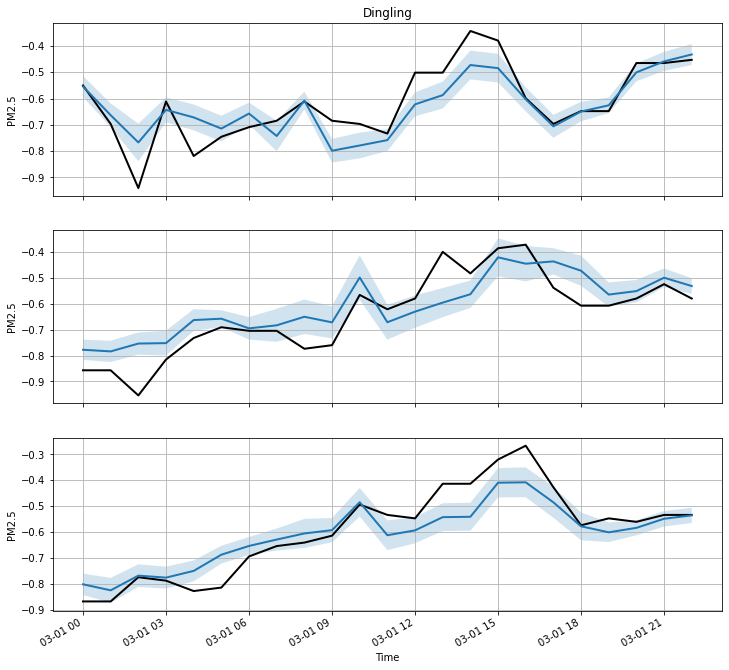

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(12, 12))

future_pred=1
names=np.ravel(gdf.index[0:23].to_frame().values)
ax1.plot(names,y_test_datasets[0,:23,future_pred], linewidth=2,color="black")
ax1.plot(names,mean_pred[0,2:25,future_pred], linewidth=2)
ax1.fill_between(names,np.ravel(mean_pred[0,2:25,future_pred]-std_pred[0,2:25,future_pred]),np.ravel(mean_pred[0,2:25,future_pred]+std_pred[0,2:25,future_pred]),alpha=0.2)
ax1.set_xlabel('Time')
ax1.set_ylabel('PM2.5')
#ax1.legend(dataset_names[0], loc="upper left", fontsize="xx-large")
ax1.grid(True)

ax2.plot(names,y_test_datasets[1,:23,future_pred], linewidth=2,color="black")
ax2.plot(names,mean_pred[1,2:25,future_pred], linewidth=2)
ax2.fill_between(names,np.ravel(mean_pred[1,2:25,future_pred]-std_pred[1,2:25,future_pred]),np.ravel(mean_pred[1,2:25,future_pred]+std_pred[1,2:25,future_pred]),alpha=0.2)
ax2.set_xlabel('Time')
ax2.set_ylabel('PM2.5')
ax1.set_title(dataset_names[1])
ax2.grid(True)

ax3.plot(names,y_test_datasets[2,:23,future_pred], linewidth=2,color="black")
ax3.plot(names,mean_pred[2,2:25,future_pred], linewidth=2)
ax3.fill_between(names,np.ravel(mean_pred[2,2:25,future_pred]-std_pred[2,2:25,future_pred]),np.ravel(mean_pred[2,2:25,future_pred]+std_pred[2,2:25,future_pred]),alpha=0.2)
ax3.set_xlabel('Time')
ax3.set_ylabel('PM2.5')
ax1.set_title(dataset_names[2])
ax3.grid(True)

fig.autofmt_xdate()

In [33]:
import jaxlib 

jaxlib.__version__

'0.4.11'

In [34]:
import flax 

flax.__version__

'0.7.1'